# Patterns Mining & Association Rules, is clustering improving?
Mining frequent patterns and association rules over the [House prices dataset (Kaggle)](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) <br> 



### 0. Imports

In [2]:
#data processing
import pandas as pd
import numpy as np
import scipy as sp

#statistics
from scipy import stats
import statsmodels.api as sm


#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


#Machine learning library
import sklearn

#Patterns Mining
from efficient_apriori import apriori

import warnings
warnings.filterwarnings("ignore")
import utils



##### Loading the CSV dataset

In [3]:
dataset_path = "../datasets/DailyTransactions.csv"
dtf = pd.read_csv(dataset_path)
dtf.columns


Index(['Date', 'Mode', 'Category', 'Subcategory', 'Note', 'Amount',
       'Income/Expense', 'Currency'],
      dtype='object')

#### Parse date column

In [4]:
dtf['Date'] = pd.to_datetime(dtf['Date'],format='mixed')
dtf['day'] = dtf['Date'].dt.day
dtf['day_name'] = dtf['Date'].dt.day_name() 

dtf['month'] = dtf['Date'].dt.month
dtf['year'] = dtf['Date'].dt.year

In [5]:

#check if any column is null
dtf.isnull().any()



Date              False
Mode              False
Category          False
Subcategory        True
Note               True
Amount            False
Income/Expense    False
Currency          False
day               False
day_name          False
month             False
year              False
dtype: bool

#### Drop possibly problematic columns

In [6]:
## Date and Note are date and text which we cant really use
dtf = dtf.drop(columns=['Date','Note'])


##### Defining numeric and categorical columns

In [7]:
numeric_columns = dtf.dtypes[(dtf.dtypes=="float64") | (dtf.dtypes=="int64")].index.tolist()
very_numerical = [nc for nc in numeric_columns if dtf[nc].nunique()>20]
categorical_columns = [c for c in dtf.columns if c not in numeric_columns]
ordinals = list(set(numeric_columns) - set(very_numerical))

##### Filling Null Values with the column's mean

In [8]:
na_columns = dtf[very_numerical].isna().sum()
na_columns = na_columns[na_columns>0]
for nc in na_columns.index:
    dtf[nc].fillna(dtf[nc].mean(),inplace=True)

##### Dropping and filling NA values for categorical columns:

1. drop if at least 70% are NA:

In [9]:
nul_cols = dtf[categorical_columns].isna().sum()/len(dtf)
drop_us = nul_cols[nul_cols>0.7]

In [10]:
dtf=dtf.drop(drop_us.index,axis=1)
categorical_columns = list(set(categorical_columns)-set(drop_us.index))

2. Fill with a new 'na' category:

In [11]:
dtf[categorical_columns]= dtf[categorical_columns].fillna('na')

##### one hot encoding/lable encoding Categorical data for clustreing

In [12]:

dtf_encoded = utils.one_hot_encoding(dtf.copy(), categorical_columns,dtype=bool)
dtf_encoded.dtypes



Amount                    float64
Currency_INR                 bool
Mode_Cash                    bool
Mode_Credit Card             bool
Mode_Debit Card              bool
                           ...   
Subcategory_na               bool
Subcategory_ropeway          bool
Subcategory_snacks           bool
Subcategory_train            bool
Subcategory_vegetables       bool
Length: 212, dtype: object

#### Find best k

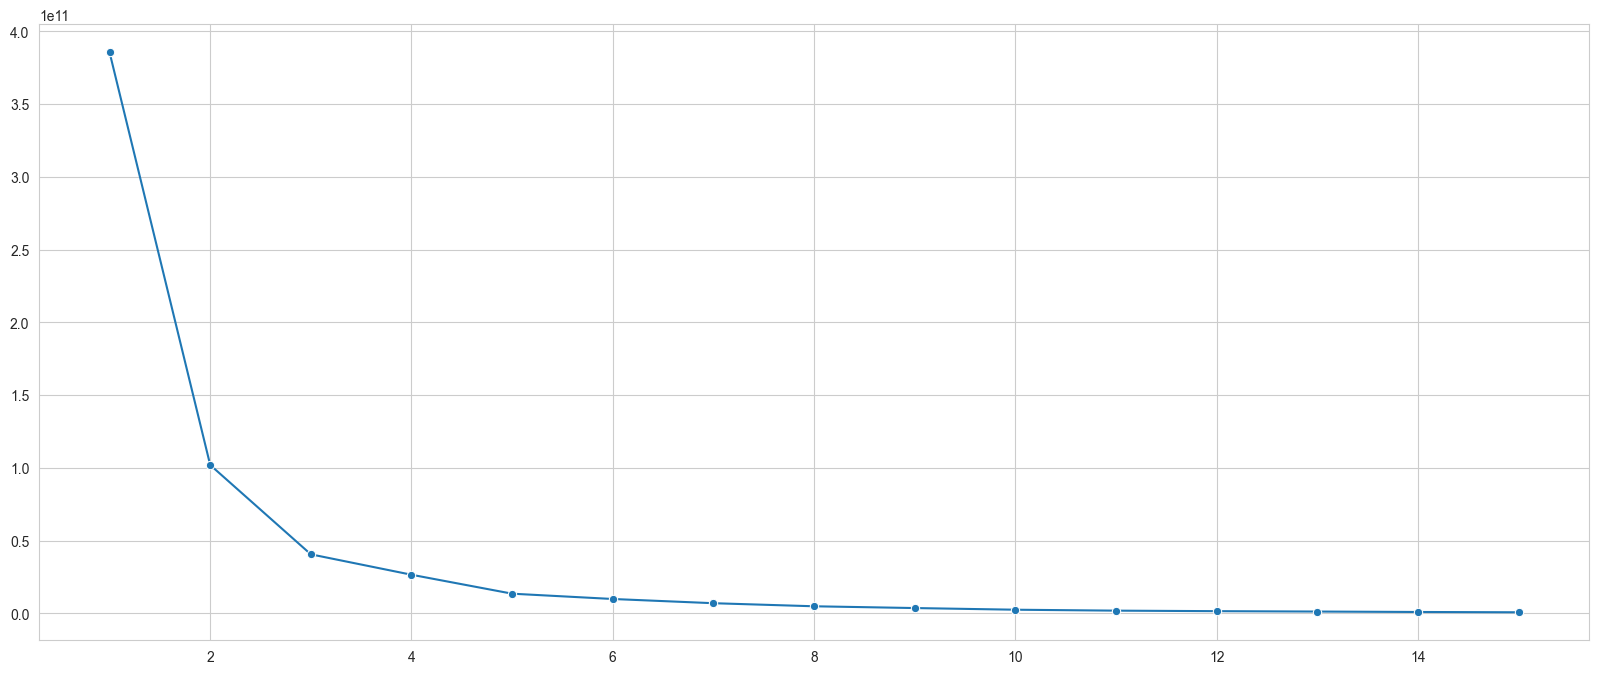

In [13]:
utils.opt_kmeans(dtf_encoded,15)

In [14]:
clusters = utils.run_k_means(6,dtf_encoded,dtf)
lens = [len(a) for a in clusters.values()]
lens

[2280, 7, 4, 13, 55, 102]

##### removing small clusters

In [15]:
labels2remove = []
for label,cdf in clusters.items():
    print(len(cdf))

    #removing clusters under 1% in size. this is just so we dont get things with very high relative support
    if len(cdf) < len(dtf)/100:
        labels2remove.append(label)
for label in labels2remove:
    del clusters[label]
len(clusters)


2280
7
4
13
55
102


3

### 2. Using Apriori on a each cluster:

### Preprocessing clusters for apriori

In [16]:
clusters[list(clusters.keys())[0]][:1]

,Mode,Category,Subcategory,Amount,Income/Expense,Currency,day,day_name,month,year
0,Cash,Transportation,Train,30.0,Expense,INR,20,Thursday,9,2018


In [17]:
for label,cdf in clusters.items():
    clusters[label] = utils.preprocess_4_apriori(cdf,very_numerical)
clusters[list(clusters.keys())[0]]

,Mode,Category,Subcategory,Amount,Income/Expense,Currency,day,day_name,month,year
0,Cash,Transportation,Train,low,Expense,INR,20,Thursday,9,2018
1,Cash,Food,snacks,low,Expense,INR,20,Thursday,9,2018
2,Saving Bank account 1,subscription,Netflix,high,Expense,INR,19,Wednesday,9,2018
3,Saving Bank account 1,subscription,Mobile Service Provider,very low,Expense,INR,17,Monday,9,2018
4,Cash,Festivals,Ganesh Pujan,high,Expense,INR,16,Sunday,9,2018
...,...,...,...,...,...,...,...,...,...,...
2456,Cash,Transportation,na,very low,Expense,INR,1,Thursday,1,2015
2457,Cash,Transportation,na,very low,Expense,INR,1,Thursday,1,2015
2458,Cash,Transportation,na,low,Expense,INR,1,Thursday,1,2015
2459,Cash,Food,na,very low,Expense,INR,1,Thursday,1,2015


In [18]:
clusters[list(clusters.keys())[0]][:1]

,Mode,Category,Subcategory,Amount,Income/Expense,Currency,day,day_name,month,year
0,Cash,Transportation,Train,low,Expense,INR,20,Thursday,9,2018


In [19]:
#might need to select only several columns for running effiency
patitioned_total_rules = set()

for label,cdf in clusters.items():
    transactions = utils.convert_ds_to_transactions(cdf)
    itemsets, rules = apriori(transactions, min_support=0.5, min_confidence=0.8,output_transaction_ids=False)
    print(len(patitioned_total_rules))
    patitioned_total_rules.update(rules)

patitioned_total_rules=list(patitioned_total_rules)
len(patitioned_total_rules)

0
2
160


204

### do apriori on the initial dataset for comparison

In [20]:
transactions = utils.convert_ds_to_transactions(dtf)
unpatitioned_total_itemsets, unpatitioned_total_rules = apriori(transactions, min_support=0.3, min_confidence=0.5,output_transaction_ids=False)

In [21]:
len(unpatitioned_total_rules)

22

## 2. Analyzing the rules:
We need a measures of interestingness to evaluate our results.

We first use the Lift measurement taught in class.
on top of that we use the Conviction and Leverage measurements.
formulas and meaning of those can be seen in the report file.

### Lift comparison

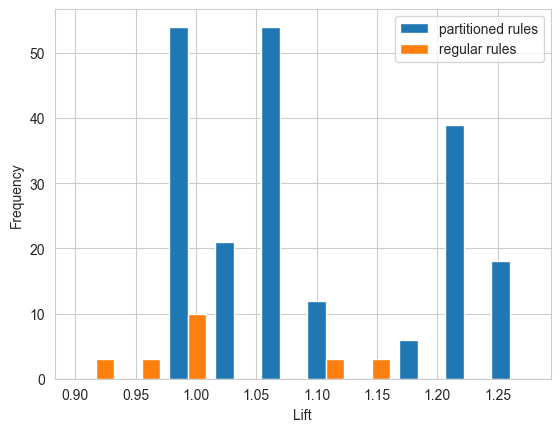

In [22]:
partitioned_lift_arr = [rule.lift for rule in patitioned_total_rules]
unpartitioned_lift_arr = [rule.lift for rule in unpatitioned_total_rules]
plt.hist([partitioned_lift_arr,unpartitioned_lift_arr])
plt.legend(['partitioned rules','regular rules'])
plt.xlabel('Lift')
plt.ylabel('Frequency')
plt.show()


### Conviction comparison

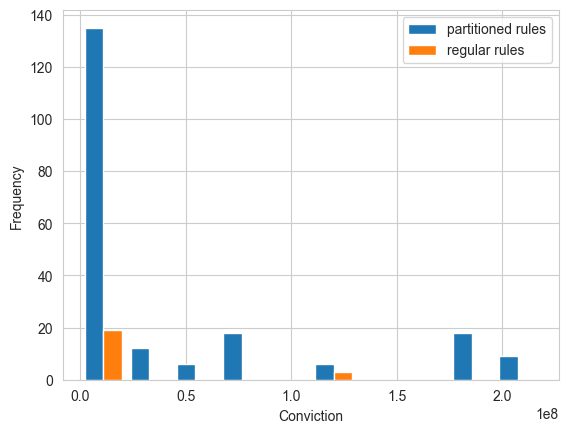

In [23]:
#creating conviction graph for both the partitioned rules and the unpartitioned rules
partitioned_conviction_arr = [rule.conviction for rule in patitioned_total_rules]
unpartitioned_conviction_arr = [rule.conviction for rule in unpatitioned_total_rules]
plt.hist([partitioned_conviction_arr,unpartitioned_conviction_arr])
plt.legend(['partitioned rules','regular rules'])
plt.xlabel('Conviction')
plt.ylabel('Frequency')

plt.show()

### Confidence comparison


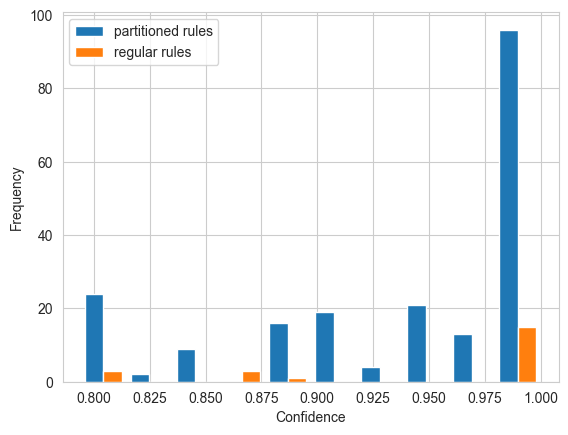

In [24]:
partitioned_conf_arr = [rule.confidence for rule in patitioned_total_rules]
unpartitioned_conf_arr = [rule.confidence for rule in unpatitioned_total_rules]
plt.hist([partitioned_conf_arr,unpartitioned_conf_arr])
plt.legend(['partitioned rules','regular rules'])
plt.xlabel('Confidence')
plt.ylabel('Frequency')

plt.show()